# Reducing Commercial Aviation Fatalities

https://www.kaggle.com/c/reducing-commercial-aviation-fatalities/data

## Exploratory Data Analysis

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

## Reading train data

In [2]:
df_train = pd.read_csv('train.csv')
df_train.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,...,37.368999,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,...,31.170799,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,...,-12.012600,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,...,18.574100,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,...,6.555440,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A


In [3]:
# Asserting that there are no Nan values in the given data
assert df_train.isnull().sum().sum() == 0, "Null values present in the data"

## Class distribution

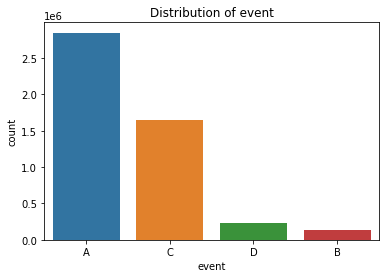

In [4]:
sns.countplot(x="event", data=df_train)
plt.title("Distribution of event")
plt.show()

**Observations**

*   There is class imbalance in the given data
*   Baseline event (A) is the majority class with highest occurence and Surprise/Startle event (B) is the minority class with the least occurrence

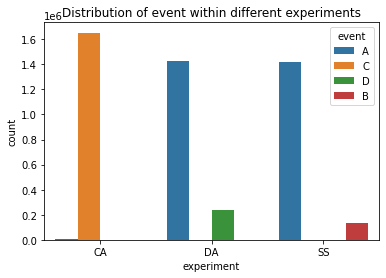

In [5]:
sns.countplot('experiment', hue='event', data=df_train)
plt.title("Distribution of event within different experiments")
plt.show()

**Observations**

* For experiment 'CA', the event 'C' (Channelised Attention) is observed most of the time and the event 'A' (Baseline state) is almost negligible
* For experiments 'DA' and 'SS', the event 'A' (Baseline state) is observed most of the time and the events 'D'(Distracted Attention) and 'B'(Startled/Surprised) respectively, are observed for only a small amount of time

**Conclusion**

* A pilot can be in 'Channelised Attention' state for prolonged period of time, whereas he/she can be in 'Distracted Attention' state and 'Startled/Surprised' state for only a short period even when conducting experiment to elicit that particular state of the pilot

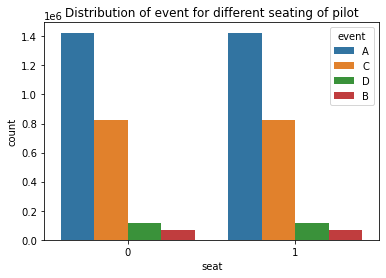

In [6]:
sns.countplot('seat', hue='event', data=df_train)
plt.title("Distribution of event for different seating of pilot")
plt.show()

**Observation**

* Both the seats have similar distribution of event

**Conclusion**

* Seating of the pilot doesn't affect the outcome

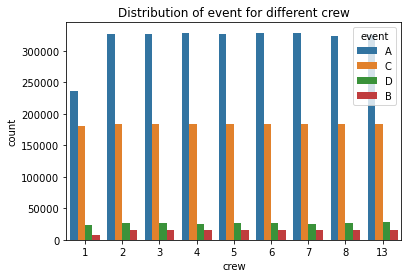

In [7]:
sns.countplot('crew', hue='event', data=df_train)
plt.title("Distribution of event for different crew")
plt.show()

**Observation**

* Different crew have similar distribution of classes, which shows that class distribution doesn't vary across pilots

## Univariate Analysis

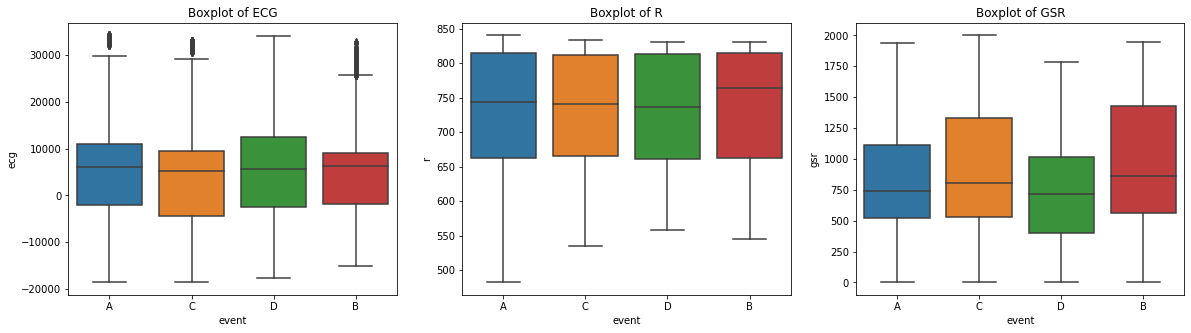

In [8]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.boxplot('event','ecg',data=df_train)
plt.title("Boxplot of ECG")
plt.subplot(1,3,2)
sns.boxplot('event','r',data=df_train)
plt.title("Boxplot of R")
plt.subplot(1,3,3)
sns.boxplot('event','gsr',data=df_train)
plt.title("Boxplot of GSR")
plt.show()

**Observation**

* ECG values are similarly distributed for all classes and hence might not be directly helpful in classification
* 'R' values have a slightly lower limit for class A compared to other classes. However, majority of values are distributed similarly for all classes, and hence might not be directly helpful in classification
* GSR values are similarly distributed for all classes and hence might not be directly helpful in classification

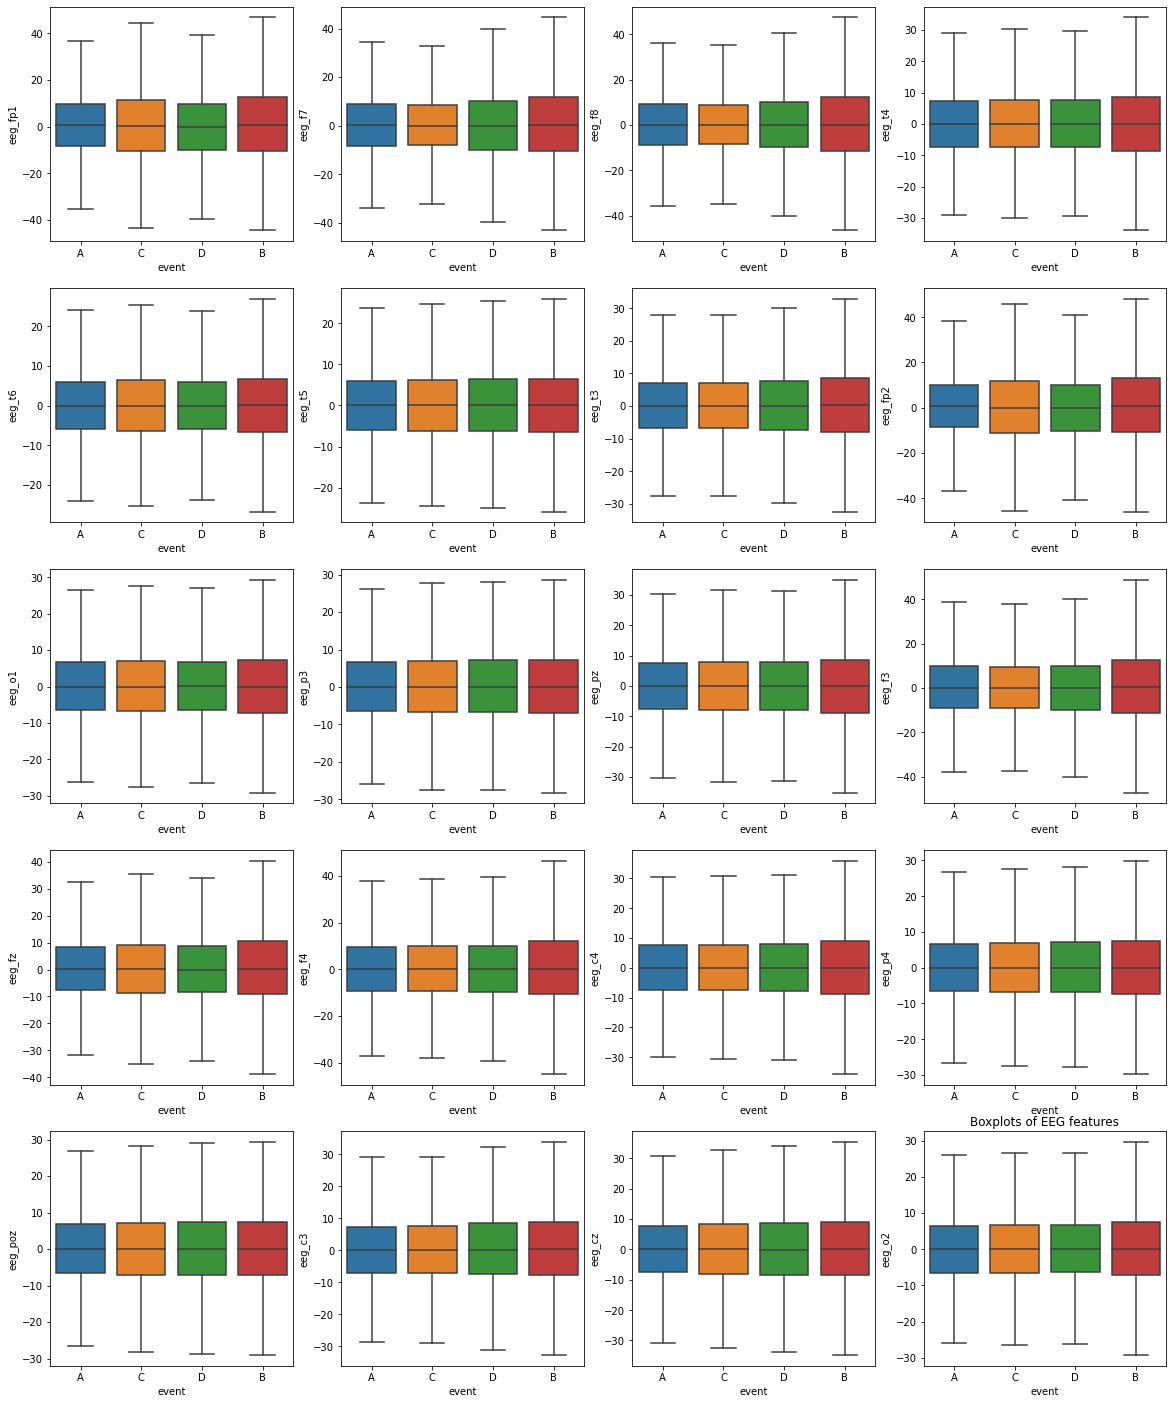

In [9]:
eeg_features = []
for column in df_train.columns:
    if column.startswith("eeg"):
        eeg_features.append(column)

# https://www.kaggle.com/ashishpatel26/smote-with-model-lightgbm
plt.figure(figsize=(20,25))
i = 0

for feature in eeg_features:
    i += 1
    plt.subplot(5, 4, i)
    sns.boxplot(x='event', y=feature, data=df_train, showfliers=False)
plt.title("Boxplots of EEG features")
plt.show()

**Observation**

* All EEG features are similarly distributed for all the events, and hence might not be directly helpful in classification

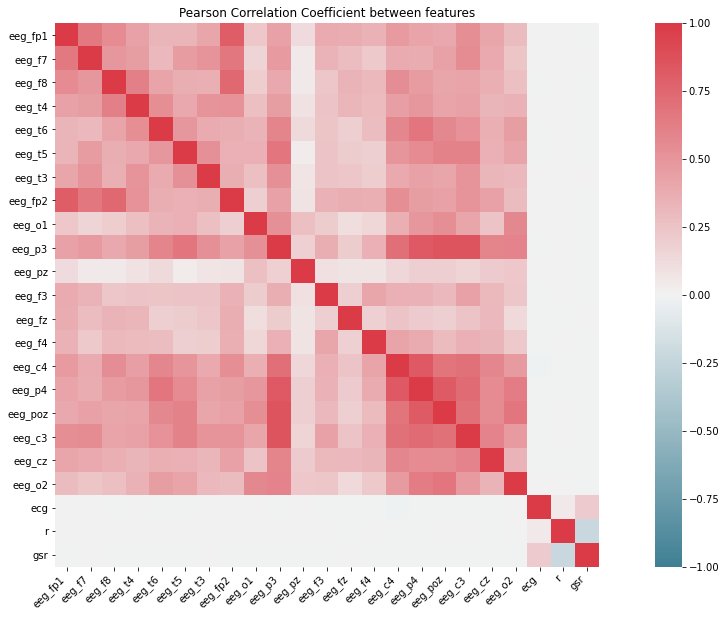

In [10]:
corr = df_train.drop(['crew','experiment','seat','time'], axis=1).corr()

fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title("Pearson Correlation Coefficient between features")
plt.show()

**Observation**

* GSR is negatively correlated to R while positively correlated with ECG
* The correlation between ECG, R and GSR with EEG features is very weak
* EEG features are generally strongly correlated to each other

In [11]:
df_train_sample1, df_train_sample2, y_sample1, y_sample2 = train_test_split(df_train.drop(['event'], axis=1), 
                                                                            df_train['event'],
                                                                            stratify=df_train['event'],
                                                                            test_size = 0.5)
df_train_sample1['event'] = y_sample1

In [12]:
interval_cols = ['eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3', 'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz', 'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr']
phik_corr = df_train_sample1.drop(['crew','experiment','seat','time'], axis=1).phik_matrix(interval_cols=interval_cols)

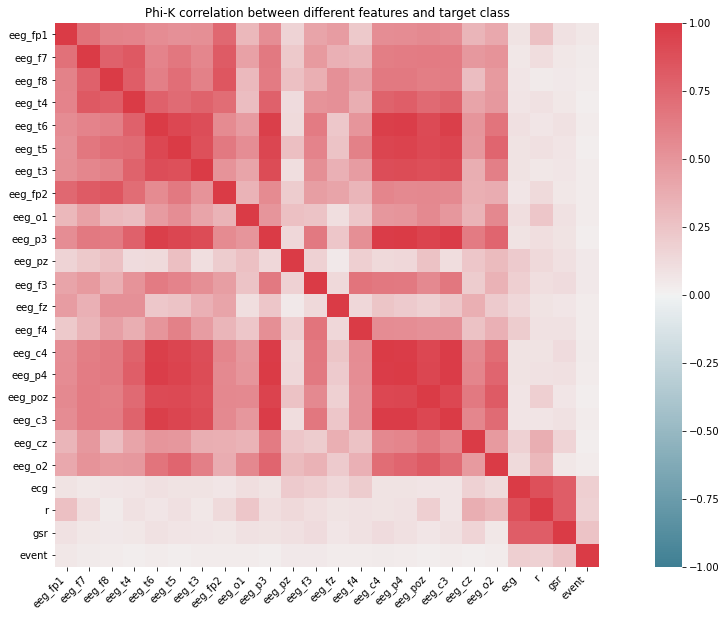

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(
    phik_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title("Phi-K correlation between different features and target class")
plt.show()

**Observation**

* Event is weakly correlated (very insignificant) to GSR, R and ECG, whereas correlation between event and EEG features is negligible. There is no single feature strongly correlated to event

## Bivariate Analysis

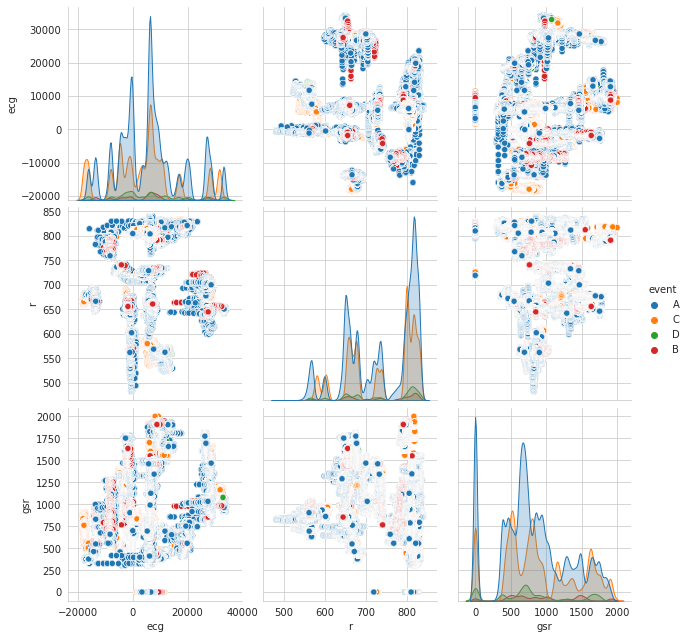

In [14]:
sns.set_style("whitegrid");
sns.pairplot(df_train, hue="event", height=3, vars=['ecg','r','gsr']);
plt.show()

**Observations**

* No pair of features produces distinct clusters of points belonging to a particular class
* The PDFs of features show that distribution of datapoints are similar for every class

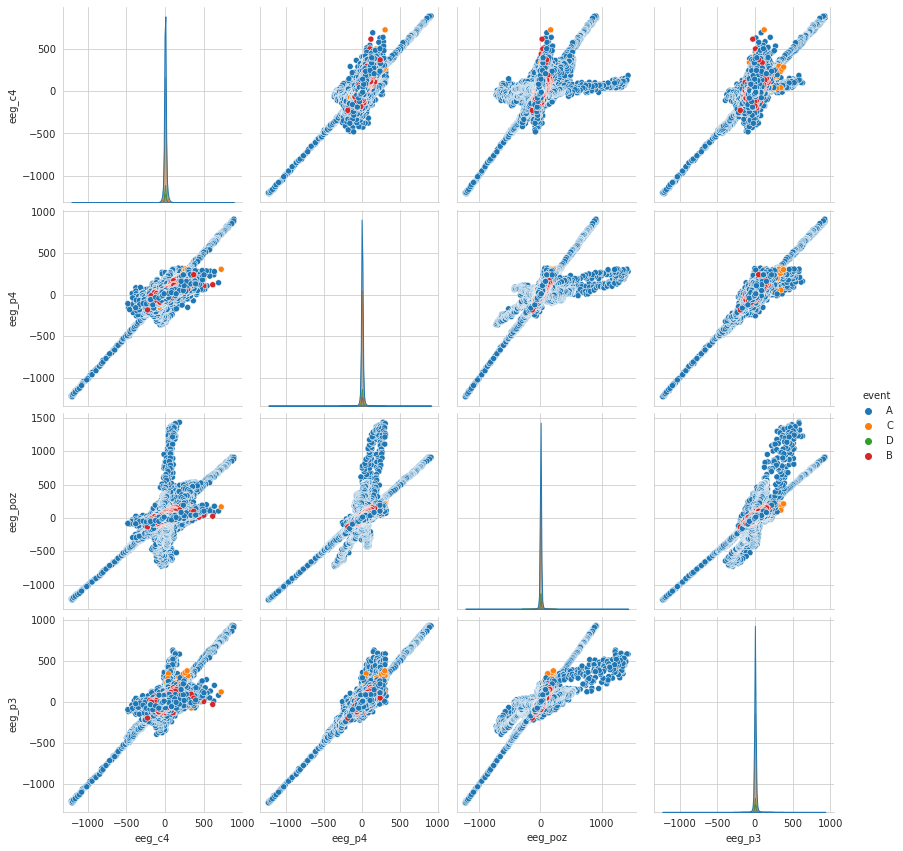

In [15]:
sns.set_style("whitegrid");
sns.pairplot(df_train, hue="event", height=3, vars=['eeg_c4','eeg_p4','eeg_poz','eeg_p3']);
plt.show()

**Observations**
* No pair of EEG features produces distinct clusters of points belonging to a particular class
* Some EEG features have a strong linear relationship between them

## Multivariate Analysis

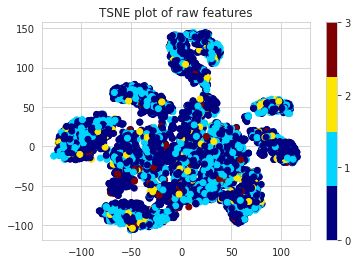

In [16]:
event_mapping = {'A': 0, 'C': 1, 'D': 2, 'B': 3}
X_raw_features = df_train.drop(['crew','experiment','time','seat','event'], axis=1)
y_raw_features = df_train['event'].apply(lambda x: event_mapping[x]).values
scaler = StandardScaler()
X_raw_features_std = scaler.fit_transform(X_raw_features) 
X_large_sample, X_small_sample, y_large_sample, y_small_sample = train_test_split(X_raw_features_std, y_raw_features, stratify=y_raw_features, test_size = 10000)
df_small_sample = pd.DataFrame(X_small_sample, columns=X_raw_features.columns)
xtsne=TSNE(perplexity=30, n_iter=5000, n_jobs=-1)
results=xtsne.fit_transform(df_small_sample)
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=y_small_sample, cmap=plt.cm.get_cmap("jet", 4))
plt.colorbar(ticks=range(4))
plt.title("TSNE plot of raw features")
plt.show()

**Observation**

* No cluster belonging to a distinct class can be formed in a two dimensional TSNE plot with the given raw features

**Conclusion**

* The raw features in the given dataset are not enough to perform classification. We need to generate new features to transform into a different feature space where classification task is simpler